In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np

In [2]:
import requests
url = 'https://drive.google.com/uc?export=download&id=1Tyk3WMrJvziEfPgtvXKcvSy--nfNqdx0'
train_actions = pd.read_parquet(url)

In [3]:
train_actions

,user_id,loc_user_id,action,date,products,pageId
0,6fd49b56-8cc6-11ed-86e0-002590c0647c,c6e357dc-121d-449d-a744-e9a0b56c2380,7,2024-09-07 00:00:04,[],2571824865
1,6fd49b56-8cc6-11ed-86e0-002590c0647c,c6e357dc-121d-449d-a744-e9a0b56c2380,7,2024-09-07 00:00:08,[],3834364438
2,f9c498ec-5d3b-11ef-86e0-002590c0647c,120c9064-1131-4dc3-8048-44184531b42e,7,2024-09-07 00:00:08,[],2448628415
3,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,7,2024-09-07 00:00:11,[],3875013967
4,badbd396-6cab-11ef-86e0-002590c0647c,73423d85-d47c-4332-8155-5200615302b5,7,2024-09-07 00:00:11,[],3025531174
...,...,...,...,...,...,...
6580931,cfdfd33e-3f63-11ea-86e0-002590c0647c,43cbc55c-afaa-489f-973f-530d36c7f540,1,2024-09-28 23:59:54,[5494144],3195814142
6580932,e48780d6-fd99-11ee-86e0-002590c0647c,a67f67ca-3f52-4a42-b613-7e2e78416125,7,2024-09-28 23:59:54,[],2659320286
6580933,4b8ef1b8-d821-11ee-86e0-002590c0647c,27e4705f-b407-46e6-aad5-1da436b2763e,7,2024-09-28 23:59:55,[],2898485070
6580934,6b7ba8f2-db89-11ee-9b7b-002590c82436,b5eb497d-0126-497e-9bfb-f30695fe687f,7,2024-09-28 23:59:55,[],2094289076


In [4]:
url = 'https://drive.google.com/uc?export=download&id=1xeIvJDwCYFDphdjzrhql7CCNSx-WLAUG'
stokman_catalog = pd.read_parquet(url)

In [5]:
train_actions['action'] = train_actions['action'].replace({0: 'view', 1:'like', 2:'addB', 3:'delB', 4:'clearB', 5:'order', 6:'listB', 7:\
                                                           'visit', 8:'visitCategory', 9:'search'})

In [6]:
train_actions['hour']=train_actions['date'].dt.hour

In [7]:
train_actions['DOW'] = train_actions['date'].dt.day_name()

In [8]:
train_actions.describe()

,date,hour
count,6580936,6.580936e+06
mean,2024-09-18 10:15:15.669016,1.226071e+01
min,2024-09-07 00:00:04,0.000000e+00
25%,2024-09-12 17:36:48,8.000000e+00
50%,2024-09-18 14:15:27,1.200000e+01
75%,2024-09-23 20:51:59,1.700000e+01
max,2024-09-28 23:59:59,2.300000e+01
std,NaN,5.344650e+00


In [9]:
print('Количество уникальных пользователей', train_actions['user_id'].nunique())

Количество уникальных пользователей 469435


In [10]:
print('Начало исследования', train_actions['date'].min())

Начало исследования 2024-09-07 00:00:04


In [11]:
print('Конец исследования', train_actions['date'].max())

Конец исследования 2024-09-28 23:59:59


In [19]:
train_actions.isna().sum()

,0
user_id,0
loc_user_id,0
action,0
date,0
products,0
pageId,0
hour,0
DOW,0


In [13]:
train_actions['products'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6580936 entries, 0 to 6580935
Series name: products
Non-Null Count    Dtype 
--------------    ----- 
6580936 non-null  object
dtypes: object(1)
memory usage: 50.2+ MB


In [18]:
train_actions['products'].apply(lambda x: len(x) == 0).sum()

5338045

# Анализ взаимодействий пользователя с товарами

**Частота взаимодействий**

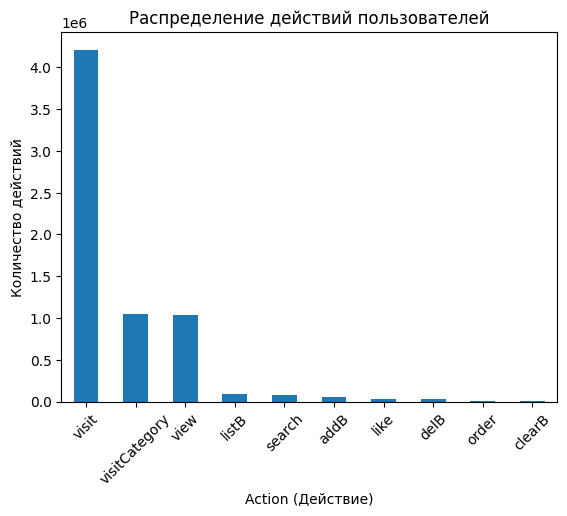

In [14]:
train_actions['action'].value_counts().plot(kind='bar')
plt.xlabel('Action (Действие)')
plt.ylabel('Количество действий')
plt.title('Распределение действий пользователей')
plt.xticks(rotation=45)

plt.show()

*Visit (посещение) — самое частое действие, встречается более 4 миллионов раз.
VisitCategory и View — также часто встречающиеся действия.
Остальные действия, такие как поиск, добавление товара в корзину, оформление заказа, встречаются значительно реже.*

Путь покупателя (воронка)

In [15]:
# Этап 1: Все пользователи, которые посмотрели товар
view_users = train_actions[train_actions['action'] == 'view']['user_id'].nunique()

# Этап 2: Все пользователи, которые добавили товар в корзину (addB)
add_to_cart_users = train_actions[train_actions['action'] == 'addB']['user_id'].nunique()

# Этап 3: Все пользователи, которые оформили заказ (order)
order_users = train_actions[train_actions['action'] == 'order']['user_id'].nunique()

# Рассчитываем конверсию с этапа на этап
conversion_view_to_cart = (add_to_cart_users / view_users) * 100 if view_users > 0 else 0
conversion_cart_to_order = (order_users / add_to_cart_users) * 100 if add_to_cart_users > 0 else 0
conversion_view_to_order = (order_users / view_users) * 100 if view_users > 0 else 0
# Вывод конверсий
print(f'Конверсия от просмотра к добавлению в корзину: {conversion_view_to_cart:.2f}%')
print(f'Конверсия от добавления в корзину к заказу: {conversion_cart_to_order:.2f}%')
print(f'Конверсия от просмотра к заказу: {conversion_view_to_order:.2f}%')

Конверсия от просмотра к добавлению в корзину: 7.39%
Конверсия от добавления в корзину к заказу: 24.38%
Конверсия от просмотра к заказу: 1.80%


*Только 7.39% пользователей, которые просматривают товары, принимают решение добавить их в корзину*

*Примерно четверть пользователей, которые добавляют товар в корзину, совершают покупку*

*Только 1.80% пользователей совершают покупку после просмотра товара*

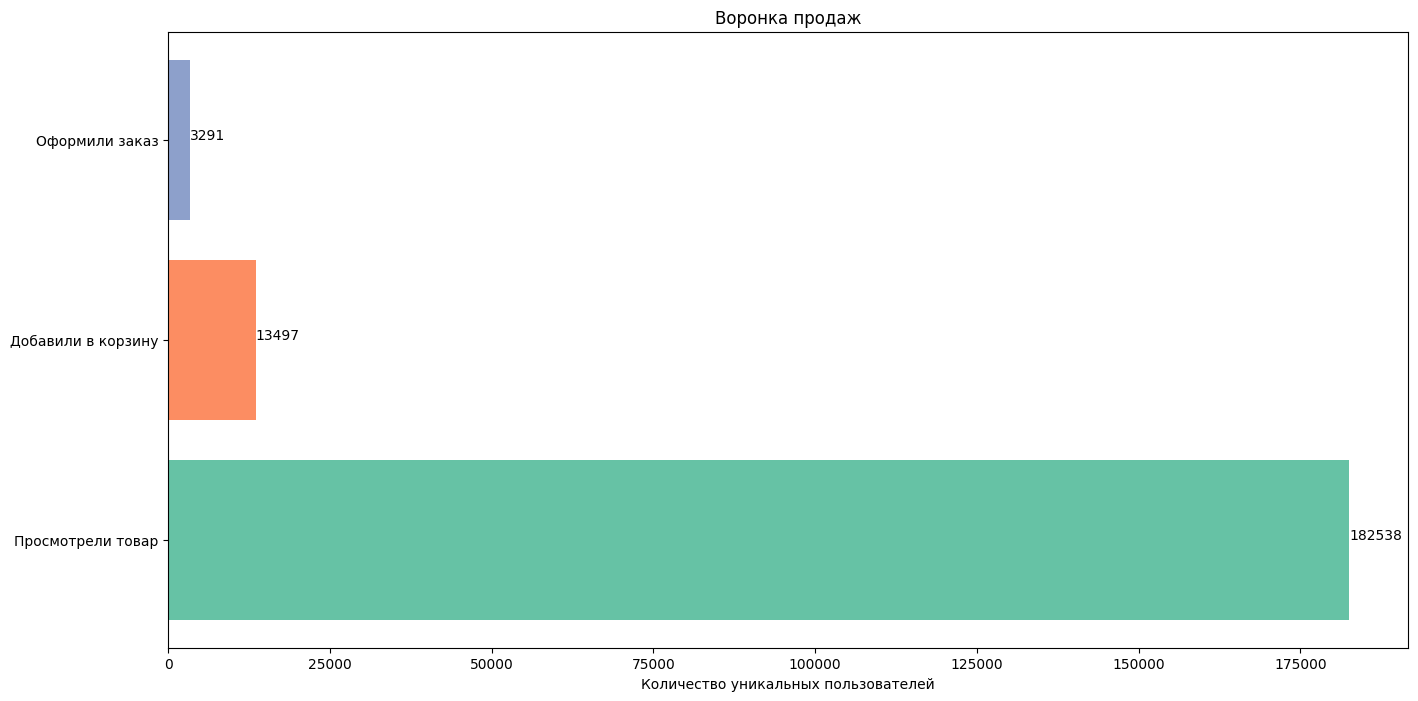

In [16]:
stages = ['Просмотрели товар', 'Добавили в корзину', 'Оформили заказ']
users_counts = [view_users, add_to_cart_users, order_users]

# Построение графика
plt.figure(figsize=(16, 8))
plt.barh(stages, users_counts, color=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.xlabel('Количество уникальных пользователей')
plt.title('Воронка продаж')

# Добавление числовых значений на графике
for index, value in enumerate(users_counts):
    plt.text(value, index, str(value))

plt.show()

*Просмотрели товар: 182 538 уникальных пользователей.*

*Добавили в корзину: 13 497 пользователей.*

*Оформили заказ: 3 291 пользователи.*


**Популярность товаров**

In [ ]:
orders = train_actions[train_actions['action'] == 'order']

# Разворачиваем списки продуктов в колонке 'products'
orders_exploded = orders.explode('products')

# Подсчитываем, сколько раз каждый товар был куплен
popular_products = orders_exploded['products'].value_counts().reset_index()

# Переименовываем колонки для удобства
popular_products.columns = ['product_id', 'purchase_count']

# Выводим топ-10 самых популярных товаров
print(popular_products.head(25))

   product_id  purchase_count
0     5143321              16
1     6450217              15
2      816040              13
3     5177335              13
4     6442393              12
5     5379376              12
6      196933              12
7     5147986              11
8     1719975              11
9     5014714              11
10    1824452              10
11     590307              10
12     196745               9
13     196749               8
14    5143264               8
15    5040520               8
16    5315323               8
17    5182846               8
18    5254909               8
19    6588023               7
20    4942600               7
21    5396188               7
22    2705119               7
23    1779354               7
24    5053528               7


*Самыми популярными товарами являются:*

*Товар с ID 5143321 — 16 покупок.*
*Товар с ID 6450217 — 15 покупок.*
*Товар с ID 816040 — 13 покупок.*
*Товар с ID 5177335 — 13 покупок.*
*Товар с ID 6442393 — 12 покупок.*
*Этот список позволяет выявить самые покупаемые товары среди всех пользователей*

**Повторные покупки**

In [ ]:
# рассчитаем, сколько раз каждый пользователь купил каждый товар
repeat_purchases = orders_exploded.groupby(['user_id', 'products']).size().reset_index(name='purchase_count')

# Оставляем только те строки, где один и тот же товар был куплен более одного раза
repeat_purchases = repeat_purchases[repeat_purchases['purchase_count'] > 1]

# Просмотр первых 10 строк с повторными покупками
repeat_purchases.head(25)

,user_id,products,purchase_count
0,000ac47a-5566-11ef-9b7b-002590c82436,5006836,2
5,0080a4d2-61cc-11ec-86e0-002590c0647c,1812977,2
7,0080a4d2-61cc-11ec-86e0-002590c0647c,3910017,2
56,0117a7a8-da18-11ee-ad8e-002590c82436,5143321,2
61,01382490-7bf0-11ef-86e0-002590c0647c,2702578,2
62,01382490-7bf0-11ef-86e0-002590c0647c,6075263,2
63,01382490-7bf0-11ef-86e0-002590c0647c,6299575,2
72,0143e38e-f8c8-11ea-8a53-0cc47a6d2fef,2682160,2
74,0143e38e-f8c8-11ea-8a53-0cc47a6d2fef,2726887,2
75,0143e38e-f8c8-11ea-8a53-0cc47a6d2fef,3728122,2


*Анализ позволяет выделить продукты, которые приобретались каждым пользователем больше 1 раза*

# Анализ покупок на основе временных данных

In [ ]:
# Разворачиваем списки продуктов в обеих выборках
add_to_cart = train_actions[train_actions['action'] == 'addB'].copy()
add_to_cart_exploded = add_to_cart.explode('products')


add_to_cart_exploded = add_to_cart_exploded.rename(columns={'date': 'date_add'})
orders_exploded = orders_exploded.rename(columns={'date': 'date_order'})

add_to_cart_exploded = add_to_cart_exploded.sort_values(by=['user_id', 'products', 'date_add'])
orders_exploded = orders_exploded.sort_values(by=['user_id', 'products', 'date_order'])

In [ ]:
add_to_cart_exploded

,user_id,loc_user_id,action,date_add,products,pageId,hour,DOW
5474323,0000bdba-5180-11eb-8a53-0cc47a6d2fef,3f30b604-13a9-48cb-bc73-92c8cef97b05,addB,2024-09-25 16:36:36,5168833,3931113102,16,Wednesday
5045056,000576f4-79eb-11ec-a6e9-002590c82437,4af46d1f-b0f0-40f9-af5c-41f50529ee97,addB,2024-09-24 08:51:16,1806876,4087447427,8,Tuesday
1412407,0006220c-6c4b-11ef-86e0-002590c0647c,eecfcc36-5201-465d-a515-d2832720992f,addB,2024-09-12 07:59:34,1653944,552813661,7,Thursday
1411875,0006220c-6c4b-11ef-86e0-002590c0647c,eecfcc36-5201-465d-a515-d2832720992f,addB,2024-09-12 07:58:53,2696074,552813661,7,Thursday
96489,000ac47a-5566-11ef-9b7b-002590c82436,ad3e5bb4-524f-4882-a309-5c23b84147af,addB,2024-09-07 11:02:46,5006836,2320008192,11,Saturday
...,...,...,...,...,...,...,...,...
1790063,ffef7980-14c6-11ee-86e0-002590c0647c,2f0a247d-9f4b-42d3-ad74-4da4b727bcb7,addB,2024-09-13 08:01:57,6220582,3679843945,8,Friday
3706370,fff62b9c-7ca9-11ec-a6e9-002590c82437,4689c52c-a5a4-49b3-ab6a-051c3d778b62,addB,2024-09-19 19:02:07,5888752,2275319244,19,Thursday
3693287,fff62b9c-7ca9-11ec-a6e9-002590c82437,4689c52c-a5a4-49b3-ab6a-051c3d778b62,addB,2024-09-19 18:19:41,6461593,2275319244,18,Thursday
3696022,fff62b9c-7ca9-11ec-a6e9-002590c82437,4689c52c-a5a4-49b3-ab6a-051c3d778b62,addB,2024-09-19 18:29:09,6990687,2275319244,18,Thursday


In [ ]:
add_to_cart_exploded = add_to_cart_exploded.sort_values('date_add')
orders_exploded = orders_exploded.sort_values('date_order')

In [ ]:
# Объединяем данные
order_time_diff = pd.merge_asof(
    add_to_cart_exploded,
    orders_exploded,
    by=['user_id', 'products'],
    left_on='date_add',  # Используем 'date_add' как ключ в первой таблице
    right_on='date_order',  # Используем 'date_order' как ключ во второй таблице
    direction='forward',
    suffixes=('_add', '_order')
)



In [ ]:
order_time_diff['time_diff'] = order_time_diff['date_order'] - order_time_diff['date_add']

# Просмотр первых результатов
order_time_diff[['user_id', 'products', 'time_diff']].head()

,user_id,products,time_diff
0,59386b5c-e64f-11ec-8086-002590c82437,6783225,NaT
1,59386b5c-e64f-11ec-8086-002590c82437,6599945,1 days 06:30:23
2,c2c3181c-67c4-11ef-9b7b-002590c82436,928673,NaT
3,59386b5c-e64f-11ec-8086-002590c82437,6368305,1 days 06:35:11
4,c2c3181c-67c4-11ef-9b7b-002590c82436,6875928,NaT


In [ ]:
# оставляем только заказы
order_time_diff=order_time_diff[order_time_diff['time_diff'].notnull()]
order_time_diff

,user_id,loc_user_id_add,action_add,date_add,products,pageId_add,hour_add,DOW_add,loc_user_id_order,action_order,date_order,pageId_order,hour_order,DOW_order,time_diff
1,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,addB,2024-09-07 00:07:07,6599945,1501622275,0,Saturday,f0745572-893f-4e50-bc52-5af47badff5a,order,2024-09-08 06:37:30,2034286663,6.0,Sunday,1 days 06:30:23
3,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,addB,2024-09-07 00:10:30,6368305,1501622275,0,Saturday,f0745572-893f-4e50-bc52-5af47badff5a,order,2024-09-08 06:45:41,4120537015,6.0,Sunday,1 days 06:35:11
8,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,addB,2024-09-07 00:16:00,6315697,1501622275,0,Saturday,f0745572-893f-4e50-bc52-5af47badff5a,order,2024-09-08 06:45:41,4120537015,6.0,Sunday,1 days 06:29:41
12,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,addB,2024-09-07 00:25:21,6222643,657553193,0,Saturday,f0745572-893f-4e50-bc52-5af47badff5a,order,2024-09-08 06:45:41,4120537015,6.0,Sunday,1 days 06:20:20
21,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,addB,2024-09-07 00:50:05,5271763,1037430585,0,Saturday,f0745572-893f-4e50-bc52-5af47badff5a,order,2024-09-08 06:45:41,4120537015,6.0,Sunday,1 days 05:55:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50053,34eb1246-8cdd-11e9-86e0-002590c0647c,59970a44-de98-4a4c-9cd6-007212e102aa,addB,2024-09-28 21:38:58,6735456,3239769687,21,Saturday,59970a44-de98-4a4c-9cd6-007212e102aa,order,2024-09-28 21:42:44,244935222,21.0,Saturday,0 days 00:03:46
50059,fbd7a216-7dcd-11ef-9b7b-002590c82436,507991c1-0dd6-431c-8f91-5e31f2391d63,addB,2024-09-28 21:46:47,6090812,685053283,21,Saturday,507991c1-0dd6-431c-8f91-5e31f2391d63,order,2024-09-28 21:52:30,3255821166,21.0,Saturday,0 days 00:05:43
50086,1d707d68-49d9-11ef-9b7b-002590c82436,9a446488-82f0-488f-a399-d4d708d51414,addB,2024-09-28 22:27:23,6301360,2083753136,22,Saturday,9a446488-82f0-488f-a399-d4d708d51414,order,2024-09-28 22:30:04,937593980,22.0,Saturday,0 days 00:02:41
50093,0da51372-3452-11ef-9b7b-002590c82436,f8369c36-a63d-4046-9c96-efb75f07b7de,addB,2024-09-28 22:57:48,6581197,3530732888,22,Saturday,f8369c36-a63d-4046-9c96-efb75f07b7de,order,2024-09-28 22:58:49,4138309519,22.0,Saturday,0 days 00:01:01


In [ ]:
print('Среднее время от добавления в корзину до покупки', order_time_diff['time_diff'].mean())
print('Медианное время от добавления в корзину до покупки', order_time_diff['time_diff'].median())

Среднее время от добавления в корзину до покупки 0 days 13:50:42.027414
Медианное время от добавления в корзину до покупки 0 days 00:11:08


*Среднее время составляет около 13 часов и 50 минут.*

*Медианное время (более характерный показатель для пользователей) составляет около 11 минут.*

*Эти результаты показывают, что большинство пользователей принимают решение о покупке относительно быстро (судя по медиане), но существует некоторое количество пользователей, которые совершают покупку спустя более продолжительное время, что отражено в среднем значении.*

**Анализ покупок по времени суток**

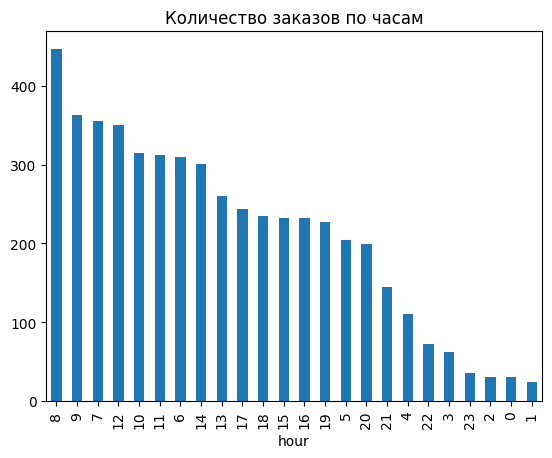

In [ ]:
# найдем распределние заказов по часам
orders['hour'].value_counts().plot(kind='bar')
plt.title('Количество заказов по часам')
plt.show()

*Пик заказов приходится на утренние часы, особенно на 8:00, что может свидетельствовать о том, что многие пользователи оформляют заказы в начале дня.*

*После 8:00 наблюдается постепенное снижение количества заказов, но активность остается высокой до обеда.*

*Вечером, после 18:00, количество заказов значительно уменьшается, с наименьшей активностью поздно вечером и ночью.*

**Анализ покупок по дням недели**

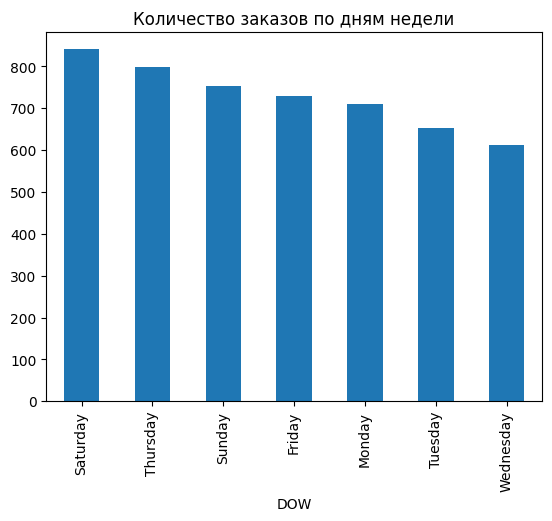

In [ ]:
orders['DOW'].value_counts().plot(kind='bar')
plt.title('Количество заказов по дням недели')
plt.show()

*Суббота является самым активным днем по количеству заказов, что подтверждает гипотезу о том, что пользователи более склонны делать покупки в выходные.*

*Четверг и воскресенье также показывают высокую активность.*

*В будние дни активность постепенно снижается, с наименьшим числом заказов в среду.*

**Покупки в последние 3 дня**

In [ ]:
# отфильтровываем данные для оптимизации памяти
train_actions_filtered = train_actions[['user_id', 'date', 'action', 'products']].copy()
orders_filtered = orders[['user_id', 'date', 'products']].copy()
train_actions_sorted = train_actions_filtered.sort_values(by='date')
# Определяем временной диапазон за последние 3 дня
# Добавляем новую колонку с границей времени за 3 дня до каждой покупки
orders_filtered.loc[:, 'start_date'] = orders_filtered['date'] - pd.Timedelta(days=3)

train_actions_sorted['date'] = train_actions_sorted['date'].astype('datetime64[ns]')
orders_filtered['start_date'] = orders_filtered['start_date'].astype('datetime64[ns]')

print(train_actions_sorted['date'].dtype)
print(orders_filtered['start_date'].dtype)

# Для каждого заказа найдем действия за 3 дня до него
# Объединяем данные с собой, чтобы сопоставить все действия за последние 3 дня перед покупкой
last_3_days_data = pd.merge_asof(
    train_actions_sorted,
    orders_filtered,
    by='user_id',
    left_on='date',
    right_on='start_date',
    direction='backward',
    suffixes=('_prev', '_order')
)

# Оставляем только те действия, которые произошли в пределах 3 дней до покупки
recent_actions = last_3_days_data[
    (last_3_days_data['date_prev'] >= last_3_days_data['start_date']) &
    (last_3_days_data['date_prev'] <= last_3_days_data['date_order'])
]

# Смотрим, что действия пользователей за последние 3 дня до покупки
recent_actions[['user_id', 'products_prev', 'date_prev', 'products_order', 'date_order']].head(10)

datetime64[ns]
datetime64[ns]


,user_id,products_prev,date_prev,products_order,date_order
3,59386b5c-e64f-11ec-8086-002590c82437,[],2024-09-07 00:00:11,"[1747191, 1747155, 1747125, 1720761]",2024-09-09 11:17:58
11,e4362420-f6ca-11ec-86e0-002590c0647c,[],2024-09-07 00:00:26,"[5422963, 4899652]",2024-09-07 00:01:12
17,59386b5c-e64f-11ec-8086-002590c82437,[],2024-09-07 00:00:31,"[1747191, 1747155, 1747125, 1720761]",2024-09-09 11:17:58
18,59386b5c-e64f-11ec-8086-002590c82437,[],2024-09-07 00:00:32,"[1747191, 1747155, 1747125, 1720761]",2024-09-09 11:17:58
19,e4362420-f6ca-11ec-86e0-002590c0647c,[],2024-09-07 00:00:41,"[5422963, 4899652]",2024-09-07 00:01:12
23,e4362420-f6ca-11ec-86e0-002590c0647c,[],2024-09-07 00:00:51,"[5422963, 4899652]",2024-09-07 00:01:12
24,59386b5c-e64f-11ec-8086-002590c82437,[],2024-09-07 00:00:51,"[1747191, 1747155, 1747125, 1720761]",2024-09-09 11:17:58
25,e4362420-f6ca-11ec-86e0-002590c0647c,[],2024-09-07 00:00:52,"[5422963, 4899652]",2024-09-07 00:01:12
35,e4362420-f6ca-11ec-86e0-002590c0647c,"[5422963, 4899652]",2024-09-07 00:01:12,"[5422963, 4899652]",2024-09-07 00:01:12
41,59386b5c-e64f-11ec-8086-002590c82437,[],2024-09-07 00:01:24,"[1747191, 1747155, 1747125, 1720761]",2024-09-09 11:17:58


In [ ]:
# находим действия с продуктами
filtered_recent_actions = recent_actions[recent_actions['products_prev'].apply(lambda x: len(x) > 0)]
filtered_recent_actions.head(10)

,user_id,date_prev,action,products_prev,date_order,products_order,start_date
35,e4362420-f6ca-11ec-86e0-002590c0647c,2024-09-07 00:01:12,order,"[5422963, 4899652]",2024-09-07 00:01:12,"[5422963, 4899652]",2024-09-04 00:01:12
113,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:02:39,view,[6783225],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58
131,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:03:00,addB,[6783225],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58
277,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:05:34,view,[6599957],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58
304,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:06:24,view,[6599954],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58
306,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:06:27,view,[6599951],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58
323,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:06:38,view,[6599945],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58
348,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:07:07,addB,[6599945],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58
353,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:07:10,view,[6599942],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58
355,59386b5c-e64f-11ec-8086-002590c82437,2024-09-07 00:07:14,view,[6599936],2024-09-09 11:17:58,"[1747191, 1747155, 1747125, 1720761]",2024-09-06 11:17:58


In [ ]:
# находим заказы за 3 предыдущих дня
recent_orders=filtered_recent_actions[filtered_recent_actions['action']=='order']
recent_orders

,user_id,date_prev,action,products_prev,date_order,products_order,start_date
35,e4362420-f6ca-11ec-86e0-002590c0647c,2024-09-07 00:01:12,order,"[5422963, 4899652]",2024-09-07 00:01:12,"[5422963, 4899652]",2024-09-04 00:01:12
2215,557fe25c-587c-11ed-86e0-002590c0647c,2024-09-07 01:07:02,order,[6853881],2024-09-07 01:13:18,[4045725],2024-09-04 01:13:18
2565,557fe25c-587c-11ed-86e0-002590c0647c,2024-09-07 01:12:05,order,[6856083],2024-09-07 01:13:18,[4045725],2024-09-04 01:13:18
2637,557fe25c-587c-11ed-86e0-002590c0647c,2024-09-07 01:13:18,order,[4045725],2024-09-07 01:13:18,[4045725],2024-09-04 01:13:18
6125,ecbaba9e-9cf9-11ee-86e0-002590c0647c,2024-09-07 02:45:08,order,[5143264],2024-09-07 02:45:08,[5143264],2024-09-04 02:45:08
...,...,...,...,...,...,...,...
6562624,34eb1246-8cdd-11e9-86e0-002590c0647c,2024-09-28 21:42:44,order,"[6736047, 6736044, 6735456]",2024-09-28 21:42:44,"[6736047, 6736044, 6735456]",2024-09-25 21:42:44
6564844,fbd7a216-7dcd-11ef-9b7b-002590c82436,2024-09-28 21:52:30,order,[6090812],2024-09-28 21:52:30,[6090812],2024-09-25 21:52:30
6571146,1d707d68-49d9-11ef-9b7b-002590c82436,2024-09-28 22:30:04,order,[6301360],2024-09-28 22:30:04,[6301360],2024-09-25 22:30:04
6574430,0da51372-3452-11ef-9b7b-002590c82436,2024-09-28 22:58:49,order,[6581197],2024-09-28 22:58:49,[6581197],2024-09-25 22:58:49


*Из данных видно заказы, которые были сделаны за последние 3 дня до последней покупки*

# Анализ товаров

**Категории товаров**

In [ ]:
# объединяем таблицы по продуктам
orders_with_categories = pd.merge(orders_exploded, stokman_catalog, left_on='products', right_on='product_id', how='left')

# Подсчитываем, сколько раз каждый пользователь покупал товары в каждой категории
category_counts = orders_with_categories.groupby(['user_id', 'category_id']).size().reset_index(name='purchase_count')

category_counts.sort_values(by='purchase_count', ascending=False)

,user_id,category_id,purchase_count
4374,99099462-af2f-11ea-86e0-002590c0647c,6567,66
2388,534ca0b0-4b60-11ee-86e0-002590c0647c,50448,46
1561,37299710-eb72-11ed-a1c4-002590c82437,50448,33
4546,9eec796e-ae30-11ed-a1c4-002590c82437,56751,30
3146,6cc0eeb0-c425-11ed-86e0-002590c0647c,295,17
...,...,...,...
3615,7e8fe7ce-82be-11ee-86e0-002590c0647c,984,1
3614,7e8fe7ce-82be-11ee-86e0-002590c0647c,7086,1
3613,7e8fe7ce-82be-11ee-86e0-002590c0647c,1702,1
3612,7e83a218-3dce-11ef-86e0-002590c0647c,6588,1


*На основе этих данных видно, какие пользователи наиболее активно покупают товары в определённых категориях.*

*Эти данные позволяют сделать вывод о том, что определённые пользователи более активно взаимодействуют с определёнными категориями*

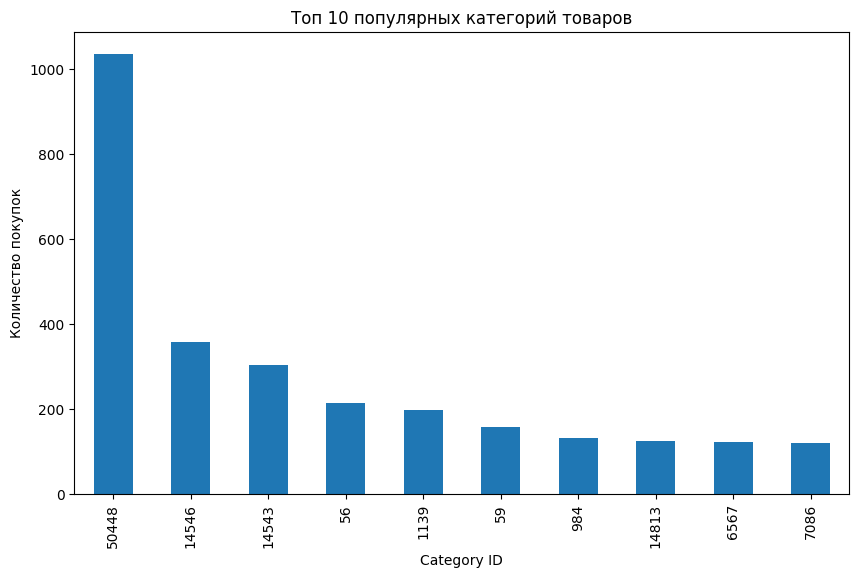

In [ ]:
# топ-10 популярных категорий
popular_categories = orders_with_categories['category_id'].value_counts().head(10)


plt.figure(figsize=(10, 6))
popular_categories.plot(kind='bar', title='Топ 10 популярных категорий товаров')
plt.xlabel('Category ID')
plt.ylabel('Количество покупок')
plt.show()

*Товары из категории 50448 являются наиболее востребованными среди пользователей*

**Связанные товары**

In [ ]:
from itertools import combinations
grouped_orders = orders_exploded.groupby(['user_id', 'date_order'])['products'].apply(list).reset_index()

# Найдем все комбинации товаров, которые покупались вместе в одном заказе
all_combinations = []
for products in grouped_orders['products']:
    if len(products) > 1:  # Рассматриваем только заказы с более чем 1 товаром
        all_combinations.extend(list(combinations(products, 2)))

# Преобразуем список комбинаций в DataFrame для подсчета частоты встречаемости каждой пары товаров
combination_df = pd.DataFrame(all_combinations, columns=['product_1', 'product_2'])

# Подсчитаем, сколько раз каждая пара товаров была куплена вместе
combination_counts = combination_df.value_counts().reset_index(name='count')

# Сортируем по количеству совместных покупок
combination_counts_sorted = combination_counts.sort_values(by='count', ascending=False)

# Выводим топ-10 товаров, которые чаще всего покупаются вместе
combination_counts_sorted.head(10)

,product_1,product_2,count
0,5177335,5177335,15
2,196745,196749,15
1,1719975,196933,15
3,6450217,6442393,13
4,816040,196749,13
5,6442393,6450217,13
6,196745,196933,12
7,6442393,5002147,12
8,1719975,196749,12
9,5932411,6442393,12


*данные могут быть полезны для создания рекомендаций для покупателей, предлагая им часто приобретаемые вместе товары*

<Figure size 1000x600 with 0 Axes>

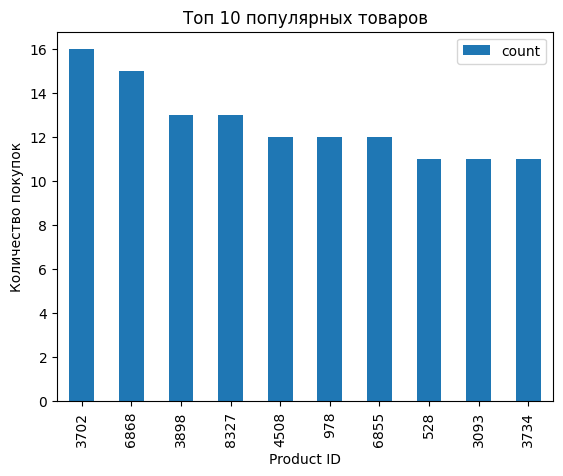

In [ ]:
# Группируем по товарам и считаем количество покупок каждого товара
popular_products=orders_exploded.groupby('products').size().reset_index(name='count')
popular_products_sorted = popular_products.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
popular_products_sorted.plot(kind='bar', title='Топ 10 популярных товаров')
plt.xlabel('Product ID')
plt.ylabel('Количество покупок')
plt.show()

*график полезен для выявления наиболее востребованных продуктов среди покупателей, что может помочь в оптимизации ассортимента*

# Гипотезы

Время добавления в корзину и вероятность покупки:

**Гипотеза: «Пользователи, которые добавляют товары в корзину вечером (с 18:00 до 24:00), с большей вероятностью совершают покупку в течение следующих 3 дней.»**

In [ ]:
from datetime import timedelta

# Фильтруем события добавления в корзину и заказы
add_to_cart = train_actions[train_actions['action'] == 'addB']
orders = train_actions[train_actions['action'] == 'order']
add_to_cart['date_x']=add_to_cart['date']
orders['date_y']=orders['date']
# Определяем вечерний диапазон
add_to_cart_evening = add_to_cart[(add_to_cart['date'].dt.hour >= 18) & (add_to_cart['date'].dt.hour <= 24)]

# Мержим данные о добавлении в корзину с заказами на основе пользователя и продукта
merged_data = pd.merge_asof(add_to_cart_evening.sort_values('date'),
                            orders.sort_values('date'),
                            by='user_id', on='date', direction='forward')

# Вычисляем время между добавлением в корзину и заказом
merged_data['time_diff'] = merged_data['date_y'] - merged_data['date_x']

# Проверка, совершена ли покупка в течение 3 дней
merged_data['purchase_within_3_days'] = merged_data['time_diff'] <= timedelta(days=3)

# Подсчёт процента пользователей, совершивших покупку
purchase_rate = merged_data['purchase_within_3_days'].mean()

print(f"Процент пользователей, совершающих покупку в течение 3 дней: {purchase_rate * 100:.2f}%")

Процент пользователей, совершающих покупку в течение 3 дней: 34.30%


<ipython-input-36-493d65fab20e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_to_cart['date_x']=add_to_cart['date']
<ipython-input-36-493d65fab20e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['date_y']=orders['date']


In [ ]:
# определяем утренний диапазон
add_to_cart_morning = add_to_cart[(add_to_cart['date'].dt.hour >= 6) & (add_to_cart['date'].dt.hour <= 12)]

# Мержим данные о добавлении в корзину с заказами на основе пользователя и продукта
merged_data = pd.merge_asof(add_to_cart_morning.sort_values('date'),
                            orders.sort_values('date'),
                            by='user_id', on='date', direction='forward')

# Вычисляем время между добавлением в корзину и заказом
merged_data['time_diff'] = merged_data['date_y'] - merged_data['date_x']

# Проверка, совершена ли покупка в течение 3 дней
merged_data['purchase_within_3_days'] = merged_data['time_diff'] <= timedelta(days=3)

# Подсчёт процента пользователей, совершивших покупку
purchase_rate = merged_data['purchase_within_3_days'].mean()

print(f"Процент пользователей, совершающих покупку в течение 3 дней: {purchase_rate * 100:.2f}%")

Процент пользователей, совершающих покупку в течение 3 дней: 34.08%


In [ ]:
# определяем обеденный диапазон
add_to_cart_noon = add_to_cart[(add_to_cart['date'].dt.hour >= 12) & (add_to_cart['date'].dt.hour <= 18)]

# Мержим данные о добавлении в корзину с заказами на основе пользователя и продукта
merged_data = pd.merge_asof(add_to_cart_noon.sort_values('date'),
                            orders.sort_values('date'),
                            by='user_id', on='date', direction='forward')

# Вычисляем время между добавлением в корзину и заказом
merged_data['time_diff'] = merged_data['date_y'] - merged_data['date_x']

# Проверка, совершена ли покупка в течение 3 дней
merged_data['purchase_within_3_days'] = merged_data['time_diff'] <= timedelta(days=3)

# Подсчёт процента пользователей, совершивших покупку
purchase_rate = merged_data['purchase_within_3_days'].mean()

print(f"Процент пользователей, совершающих покупку в течение 3 дней: {purchase_rate * 100:.2f}%")

Процент пользователей, совершающих покупку в течение 3 дней: 33.66%


*Процент совершения покупки в течение 3-х дней не зависит от времени добавления товара в корзину*

Частота просмотров и покупок:

**Гипотеза: «Пользователи, которые просматривают товар 3 или более раз, с большей вероятностью покупают его, чем те, кто просматривает товар менее 3 раз.»**

In [ ]:
train_actions_reduced = train_actions[['user_id', 'action', 'products', 'date']]

# Выполняем explode на этой версии данных
train_actions_exploded = train_actions_reduced.explode('products')

# Теперь выполняем групповую операцию
views = train_actions_exploded[train_actions_exploded['action'] == 'view']

# Подсчёт количества просмотров товаров пользователями
view_counts = views.groupby(['user_id', 'products']).size().reset_index(name='view_count')

# Добавляем заказы пользователей
view_and_orders = pd.merge(view_counts, orders_exploded, on=['user_id', 'products'], how='left', indicator=True)

# Определяем процент тех, кто купил товар после 3 и более просмотров
purchase_rate_after_multiple_views = view_and_orders[view_and_orders['view_count'] >= 3]['_merge'].value_counts(normalize=True)

print(f"Процент пользователей, купивших товар после 3 и более просмотров: {purchase_rate_after_multiple_views['both'] * 100:.2f}%")

Процент пользователей, купивших товар после 3 и более просмотров: 10.71%


In [ ]:
# Определяем процент тех, кто купил товар после 3 и более просмотров
purchase_rate_before_multiple_views = view_and_orders[view_and_orders['view_count'] < 3]['_merge'].value_counts(normalize=True)

print(f"Процент пользователей, купивших товар после менее просмотров: {purchase_rate_before_multiple_views['both'] * 100:.2f}%")

Процент пользователей, купивших товар после менее просмотров: 0.75%


Покупки по дням недели:

Гипотеза: «Средний чек в выходные дни выше, чем в будние дни»

In [ ]:
orders_with_categories

,user_id,loc_user_id,action,date_order,products,pageId,hour,DOW,add_date,shop_id,product_id,category_id,price,title,old_price
0,e4362420-f6ca-11ec-86e0-002590c0647c,8c42592d-1709-4bff-8761-a53e7f3fd9c5,order,2024-09-07 00:01:12,4899652,4263215769,0,Saturday,2024-09-28 03:07:13,350,4899652,389,10490.0,30035 28258 58315 46732 29313 52878 32899,14990.0
1,e4362420-f6ca-11ec-86e0-002590c0647c,8c42592d-1709-4bff-8761-a53e7f3fd9c5,order,2024-09-07 00:01:12,5422963,4263215769,0,Saturday,2024-09-26 03:07:08,350,5422963,2247,13290.0,30744 37270 46732 29313 52878 60036 63016,18990.0
2,557fe25c-587c-11ed-86e0-002590c0647c,4c30bb9f-e230-488c-88c2-f6af0c72c1d2,order,2024-09-07 01:07:02,6853881,8dbfb385-ff93-45d0-83d2-fec896433c4b,1,Saturday,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,557fe25c-587c-11ed-86e0-002590c0647c,4c30bb9f-e230-488c-88c2-f6af0c72c1d2,order,2024-09-07 01:12:05,6856083,4c8982bc-5a2d-47f9-8cf5-5f47bc614f12,1,Saturday,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,557fe25c-587c-11ed-86e0-002590c0647c,4c30bb9f-e230-488c-88c2-f6af0c72c1d2,order,2024-09-07 01:13:18,4045725,2f3af9ee-65b7-4dc2-8c56-6fbf0601f43e,1,Saturday,2024-09-30 03:07:09,350,4045725,7086,1690.0,20246 58457 46732 26240 42949,3390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11797,34eb1246-8cdd-11e9-86e0-002590c0647c,59970a44-de98-4a4c-9cd6-007212e102aa,order,2024-09-28 21:42:44,6736047,244935222,21,Saturday,2024-09-25 00:07:10,350,6736047,50448,480.0,55847 56144 44630,690.0
11798,fbd7a216-7dcd-11ef-9b7b-002590c82436,507991c1-0dd6-431c-8f91-5e31f2391d63,order,2024-09-28 21:52:30,6090812,3255821166,21,Saturday,2024-09-30 03:07:09,350,6090812,59,8390.0,5814 19652 60457 6844,11990.0
11799,1d707d68-49d9-11ef-9b7b-002590c82436,9a446488-82f0-488f-a399-d4d708d51414,order,2024-09-28 22:30:04,6301360,937593980,22,Saturday,2024-09-30 03:07:09,350,6301360,1711,22990.0,31799 1620 46732 36316 8847 37619,22990.0
11800,0da51372-3452-11ef-9b7b-002590c82436,f8369c36-a63d-4046-9c96-efb75f07b7de,order,2024-09-28 22:58:49,6581197,4138309519,22,Saturday,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Разделение на будние и выходные
orders_with_categories['is_weekend'] = orders_with_categories['DOW'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Сравнение средней стоимости покупок
avg_purchase_price = orders_with_categories.groupby('is_weekend')['price'].mean()

# Вывод результатов

avg_purchase_price

,price
is_weekend,
Weekday,7836.432816
Weekend,7035.135517


*результаты подтверждают гипотезу, что повторные взаимодействия с товаром (например, его многократные просмотры) повышают вероятность покупки.*

**Гипотеза: «Пользователи, которые сначала просматривают товарную категорию и затем добавляют товар в корзину, с большей вероятностью покупают товар, чем те, кто переходит сразу к просмотру товара.»**

In [ ]:
# Разделим пользователей на две группы:
# Группа 1: пользователи, которые сначала посещают категорию товаров
category_to_cart_users = train_actions[
    (train_actions['action'] == 'visitCategory') &
    (train_actions['action'].shift(-1) == 'addB')
]['user_id'].unique()

# Группа 2: пользователи, которые сначала просматривают товар
view_to_cart_users = train_actions[
    (train_actions['action'] == 'view') &
    (train_actions['action'].shift(-1) == 'addB')
]['user_id'].unique()

# Подсчитываем завершенные покупки для пользователей из обеих групп
# Для этого ищем пользователей, которые совершили действия 'order' после добавления в корзину

# Покупки после посещения категории
category_to_cart_orders = train_actions[
    (train_actions['user_id'].isin(category_to_cart_users)) &
    (train_actions['action'] == 'order')
]['user_id'].nunique()

# Покупки после просмотра товара
view_to_cart_orders = train_actions[
    (train_actions['user_id'].isin(view_to_cart_users)) &
    (train_actions['action'] == 'order')
]['user_id'].nunique()

# Общие пользователи, добавлявшие в корзину
category_to_cart_total = len(category_to_cart_users)
view_to_cart_total = len(view_to_cart_users)

# Рассчитаем процент завершенных покупок
category_to_cart_conversion = (category_to_cart_orders / category_to_cart_total) * 100
view_to_cart_conversion = (view_to_cart_orders / view_to_cart_total) * 100

# Вывод результатов
print(f"Процент завершенных покупок после посещения категории: {category_to_cart_conversion:.2f}%")
print(f"Процент завершенных покупок после просмотра товара: {view_to_cart_conversion:.2f}%")

Процент завершенных покупок после посещения категории: 10.89%
Процент завершенных покупок после просмотра товара: 16.48%


*просмотр конкретных товаров приводит к более высокой конверсии по сравнению с простым посещением категории товаров*

**Гипотеза:** **«пользователи, которые покупают дорогие товары (средний чек выше 10 000), склонны делать покупки реже, чем те, кто покупает недорогие товары»**

In [ ]:
orders_with_categories['total_price'] = orders_with_categories['price'] * orders_with_categories['products'].str.len()

# Рассчитываем средний чек для каждого пользователя
average_check_per_user = orders_with_categories.groupby('user_id')['total_price'].mean().reset_index()
average_check_per_user.columns = ['user_id', 'average_check']

# Шаг 2: Разделим пользователей на группы по среднему чеку
high_check_users = average_check_per_user[average_check_per_user['average_check'] > 10000]['user_id']
low_check_users = average_check_per_user[average_check_per_user['average_check'] <= 10000]['user_id']

# Шаг 3: Рассчитываем частоту покупок для каждой группы
# Подсчитаем количество покупок для пользователей с высоким и низким средним чеком
high_check_order_count = train_actions[
    (train_actions['user_id'].isin(high_check_users)) &
    (train_actions['action'] == 'order')
].groupby('user_id').size().mean()

low_check_order_count = train_actions[
    (train_actions['user_id'].isin(low_check_users)) &
    (train_actions['action'] == 'order')
].groupby('user_id').size().mean()

# Вывод результатов
print(f"Средняя частота покупок пользователей с высоким средним чеком (>10 000): {high_check_order_count:.2f}")
print(f"Средняя частота покупок пользователей с низким средним чеком (<=10 000): {low_check_order_count:.2f}")

Средняя частота покупок пользователей с высоким средним чеком (>10 000): 1.57
Средняя частота покупок пользователей с низким средним чеком (<=10 000): 1.45


*Частота покупок не зависит от среднего чека пользователя*